In [1]:
print("Hello, Colab!")

Hello, Colab!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import torch
import warnings
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit, train_test_split

from transformers import AutoTokenizer, AutoModel
from transformers import BertTokenizer, BertModel
from transformers import AutoConfig
from transformers import Trainer, TrainingArguments

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef
)

# Ignore all warnings
warnings.filterwarnings("ignore")

In [4]:
filepath = '/content/drive/My Drive/nlp/dataset_final/finsen_s&p500/multimodal_S&P500_all.csv'
filepath_num = '/content/drive/My Drive/nlp/dataset_final/finsen_s&p500/merged_S&P500.csv'
data = pd.read_csv(filepath)
data_num = pd.read_csv(filepath_num)
data.head()
data_num.head()

,Unnamed: 0,Date,Open,Close,High,Volume,aggregate_sentiment_score,Movement,Daily_Return,Volatility,sentiment_volatility,sentiment_volatility_lag1,aggregate_sentiment_score_lag1,Close_lag1,High_lag1,Volume_lag1,Daily_Return_lag1,Volatility_lag1
0,12,2007-08-01,1455.18,1465.81,1468.38,5.256780e+09,-0.15,0,0.724264,1.257202,0.270222,0.268142,0.00,1455.27,1488.30,4.524520e+09,-0.251552,0.991957
1,13,2007-08-07,1467.61,1476.70,1488.30,4.909390e+09,0.00,1,0.742934,1.384401,0.262336,0.270222,-0.15,1465.81,1468.38,5.256780e+09,0.724264,1.257202
2,14,2007-08-10,1453.08,1453.64,1462.02,5.345780e+09,-0.67,0,-1.561590,1.159805,0.367736,0.262336,0.00,1476.70,1488.30,4.909390e+09,0.742934,1.384401
3,15,2007-08-13,1453.42,1452.92,1466.29,3.696280e+09,-0.20,0,-0.049531,0.942009,0.275372,0.367736,-0.67,1453.64,1462.02,5.345780e+09,-1.561590,1.159805
4,16,2007-08-14,1452.86,1426.54,1456.73,3.814630e+09,-0.23,0,-1.815654,1.229445,0.250898,0.275372,-0.20,1452.92,1466.29,3.696280e+09,-0.049531,0.942009


In [5]:
# Convert the Date columns to datetime
data['Date'] = pd.to_datetime(data['Date'])
data_num['Date'] = pd.to_datetime(data_num['Date'])

# Merge data with the Daily_Return column from data_num using an inner join
merged_data = pd.merge(data, data_num[['Date', 'Daily_Return']], on='Date', how='inner')

# Optionally, view the result
merged_data.head()

,Unnamed: 0,Date,Open,Movement,sentiment_volatility_lag1,aggregate_sentiment_score_lag1,Close_lag1,High_lag1,Volume_lag1,Daily_Return_lag1,Volatility_lag1,garch_cond_variance_lag1,garch_cond_volatility_lag1,garch_residuals_lag1,rolling_cond_volatility_3_lag1,rolling_cond_volatility_5_lag1,Title,cleaned_content,Daily_Return
0,0,2007-08-01,1455.18,0,0.268142,0.00,1455.27,1488.30,4.524520e+09,-0.251552,0.991957,NaN,NaN,NaN,NaN,NaN,U.S. Companies added the smallest number of jo...,U.S. Companies added the smallest number of jo...,0.724264
1,1,2007-08-07,1467.61,1,0.270222,-0.15,1465.81,1468.38,5.256780e+09,0.724264,1.257202,1.440581,1.200242,0.721654,NaN,NaN,US Federal Reserve keeps interest rates unchan...,US Federal Reserve keeps interest rates unchan...,0.742934
2,2,2007-08-10,1453.08,0,0.262336,0.00,1476.70,1488.30,4.909390e+09,0.742934,1.384401,1.311621,1.145260,0.740188,NaN,NaN,Stock Markets Fall Worldwide! Recession?,Stock Markets Fall Worldwide! Recession?United...,-1.561590
3,3,2007-08-13,1453.42,0,0.367736,-0.67,1453.64,1462.02,5.345780e+09,-1.561590,1.159805,1.517074,1.231695,-1.573911,1.423092,NaN,Goldman Sachs fights back by putting $3 billio...,Goldman Sachs fights back by putting $3 billio...,-0.049531
4,4,2007-08-14,1452.86,0,0.275372,-0.20,1452.92,1466.29,3.696280e+09,-0.049531,0.942009,1.286727,1.134340,-0.049543,1.371807,NaN,U.S. Trade Deficit Narrows in June to $58.1 Bln,U.S. Trade Deficit Narrows in June to $58.1 Bl...,-1.815654


In [6]:
if 'Unnamed: 0' in merged_data.columns:
    merged_data = merged_data.drop(columns=['Unnamed: 0'])
merged_data.head()


,Date,Open,Movement,sentiment_volatility_lag1,aggregate_sentiment_score_lag1,Close_lag1,High_lag1,Volume_lag1,Daily_Return_lag1,Volatility_lag1,garch_cond_variance_lag1,garch_cond_volatility_lag1,garch_residuals_lag1,rolling_cond_volatility_3_lag1,rolling_cond_volatility_5_lag1,Title,cleaned_content,Daily_Return
0,2007-08-01,1455.18,0,0.268142,0.00,1455.27,1488.30,4.524520e+09,-0.251552,0.991957,NaN,NaN,NaN,NaN,NaN,U.S. Companies added the smallest number of jo...,U.S. Companies added the smallest number of jo...,0.724264
1,2007-08-07,1467.61,1,0.270222,-0.15,1465.81,1468.38,5.256780e+09,0.724264,1.257202,1.440581,1.200242,0.721654,NaN,NaN,US Federal Reserve keeps interest rates unchan...,US Federal Reserve keeps interest rates unchan...,0.742934
2,2007-08-10,1453.08,0,0.262336,0.00,1476.70,1488.30,4.909390e+09,0.742934,1.384401,1.311621,1.145260,0.740188,NaN,NaN,Stock Markets Fall Worldwide! Recession?,Stock Markets Fall Worldwide! Recession?United...,-1.561590
3,2007-08-13,1453.42,0,0.367736,-0.67,1453.64,1462.02,5.345780e+09,-1.561590,1.159805,1.517074,1.231695,-1.573911,1.423092,NaN,Goldman Sachs fights back by putting $3 billio...,Goldman Sachs fights back by putting $3 billio...,-0.049531
4,2007-08-14,1452.86,0,0.275372,-0.20,1452.92,1466.29,3.696280e+09,-0.049531,0.942009,1.286727,1.134340,-0.049543,1.371807,NaN,U.S. Trade Deficit Narrows in June to $58.1 Bln,U.S. Trade Deficit Narrows in June to $58.1 Bl...,-1.815654


In [7]:
merged_data.columns

Index(['Date', 'Open', 'Movement', 'sentiment_volatility_lag1',
       'aggregate_sentiment_score_lag1', 'Close_lag1', 'High_lag1',
       'Volume_lag1', 'Daily_Return_lag1', 'Volatility_lag1',
       'garch_cond_variance_lag1', 'garch_cond_volatility_lag1',
       'garch_residuals_lag1', 'rolling_cond_volatility_3_lag1',
       'rolling_cond_volatility_5_lag1', 'Title', 'cleaned_content',
       'Daily_Return'],
      dtype='object')

In [8]:
# Handling missing values in rolling features
rolling_features = [
    'garch_cond_variance_lag1',
    'garch_cond_volatility_lag1',
       'garch_residuals_lag1',
    'rolling_cond_volatility_3_lag1',
       'rolling_cond_volatility_5_lag1'
]  # Add any other rolling features here

# Drop rows with missing values
merged_data = merged_data.drop(columns=rolling_features).reset_index(drop=True)
merged_data.head()

,Date,Open,Movement,sentiment_volatility_lag1,aggregate_sentiment_score_lag1,Close_lag1,High_lag1,Volume_lag1,Daily_Return_lag1,Volatility_lag1,Title,cleaned_content,Daily_Return
0,2007-08-01,1455.18,0,0.268142,0.00,1455.27,1488.30,4.524520e+09,-0.251552,0.991957,U.S. Companies added the smallest number of jo...,U.S. Companies added the smallest number of jo...,0.724264
1,2007-08-07,1467.61,1,0.270222,-0.15,1465.81,1468.38,5.256780e+09,0.724264,1.257202,US Federal Reserve keeps interest rates unchan...,US Federal Reserve keeps interest rates unchan...,0.742934
2,2007-08-10,1453.08,0,0.262336,0.00,1476.70,1488.30,4.909390e+09,0.742934,1.384401,Stock Markets Fall Worldwide! Recession?,Stock Markets Fall Worldwide! Recession?United...,-1.561590
3,2007-08-13,1453.42,0,0.367736,-0.67,1453.64,1462.02,5.345780e+09,-1.561590,1.159805,Goldman Sachs fights back by putting $3 billio...,Goldman Sachs fights back by putting $3 billio...,-0.049531
4,2007-08-14,1452.86,0,0.275372,-0.20,1452.92,1466.29,3.696280e+09,-0.049531,0.942009,U.S. Trade Deficit Narrows in June to $58.1 Bln,U.S. Trade Deficit Narrows in June to $58.1 Bl...,-1.815654


In [9]:
merged_data.head()

,Date,Open,Movement,sentiment_volatility_lag1,aggregate_sentiment_score_lag1,Close_lag1,High_lag1,Volume_lag1,Daily_Return_lag1,Volatility_lag1,Title,cleaned_content,Daily_Return
0,2007-08-01,1455.18,0,0.268142,0.00,1455.27,1488.30,4.524520e+09,-0.251552,0.991957,U.S. Companies added the smallest number of jo...,U.S. Companies added the smallest number of jo...,0.724264
1,2007-08-07,1467.61,1,0.270222,-0.15,1465.81,1468.38,5.256780e+09,0.724264,1.257202,US Federal Reserve keeps interest rates unchan...,US Federal Reserve keeps interest rates unchan...,0.742934
2,2007-08-10,1453.08,0,0.262336,0.00,1476.70,1488.30,4.909390e+09,0.742934,1.384401,Stock Markets Fall Worldwide! Recession?,Stock Markets Fall Worldwide! Recession?United...,-1.561590
3,2007-08-13,1453.42,0,0.367736,-0.67,1453.64,1462.02,5.345780e+09,-1.561590,1.159805,Goldman Sachs fights back by putting $3 billio...,Goldman Sachs fights back by putting $3 billio...,-0.049531
4,2007-08-14,1452.86,0,0.275372,-0.20,1452.92,1466.29,3.696280e+09,-0.049531,0.942009,U.S. Trade Deficit Narrows in June to $58.1 Bln,U.S. Trade Deficit Narrows in June to $58.1 Bl...,-1.815654


***Generate embeddings***

In [10]:
# ----------------------------
# Set device: use collab if available, otherwise CPU
# ----------------------------
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using device:", device)


# ----------------------------
# Load DeBERTa v3 base model and tokenizer
# ----------------------------
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.to(device)
model.eval()

def get_embedding(text):
    """
    Generate an embedding for the input text using DeBERTa v3 base on the specified device.
    Returns the CLS token embedding as the sentence representation.
    """
    # Set max_length to 512 (default for DeBERTa v3 base)
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    # Move inputs to the device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # shape: (1, hidden_size)
    # Move embedding back to CPU before converting to numpy
    return cls_embedding.squeeze(0).cpu().numpy()

# ----------------------------
# Load and sort the dataset
# ----------------------------
df = merged_data.copy()  # Assumes 'merged_data' is already defined elsewhere
df['Date'] = pd.to_datetime(df['Date'])

# ----------------------------
# Iterate over all unique dates to compute aggregated embedding
# using the last available date (with articles) in the dataset
# ----------------------------
unique_dates = np.sort(df['Date'].unique())
prev_date_embeddings = {}

for current_date in unique_dates:
    # Get all dates strictly less than the current_date
    available_dates = df[df['Date'] < current_date]['Date']
    if available_dates.empty:
        print(f"No previous date available for {pd.Timestamp(current_date).date()}. Using zero vector.")
        embedding = np.zeros(768)
    else:
        # Use the last available date prior to current_date
        last_available_date = available_dates.max()
        print(f"For current date {pd.Timestamp(current_date).date()}, last available date is {pd.Timestamp(last_available_date).date()}")

        # Retrieve articles for that date
        articles = df[df['Date'] == last_available_date]['cleaned_content']
        if articles.empty:
            print(f"No articles found for date {pd.Timestamp(last_available_date).date()}, using zero vector.")
            embedding = np.zeros(768)
        else:
            embeddings = [get_embedding(article) for article in articles]
            embedding = np.mean(embeddings, axis=0)
    prev_date_embeddings[current_date] = embedding

# Map the computed embeddings back to the DataFrame
df['prev_day_embedding'] = df['Date'].map(prev_date_embeddings)

# Debug print: check the embedding shape for the first row
print("First row aggregated previous date embedding shape:", df.iloc[0]['prev_day_embedding'].shape)

Using device: cuda


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

No previous date available for 2007-08-01. Using zero vector.
For current date 2007-08-07, last available date is 2007-08-01
For current date 2007-08-10, last available date is 2007-08-07
For current date 2007-08-13, last available date is 2007-08-10
For current date 2007-08-14, last available date is 2007-08-13
For current date 2007-08-15, last available date is 2007-08-14
For current date 2007-08-16, last available date is 2007-08-15
For current date 2007-08-17, last available date is 2007-08-16
For current date 2007-08-20, last available date is 2007-08-17
For current date 2007-08-28, last available date is 2007-08-20
For current date 2007-08-29, last available date is 2007-08-28
For current date 2007-08-30, last available date is 2007-08-29
For current date 2007-08-31, last available date is 2007-08-30
For current date 2007-09-04, last available date is 2007-08-31
For current date 2007-09-07, last available date is 2007-09-04
For current date 2007-09-10, last available date is 2007

In [11]:
# Define the numerical columns
numerical_cols = ['Open','sentiment_volatility_lag1',
       'aggregate_sentiment_score_lag1', 'Close_lag1', 'High_lag1',
       'Volume_lag1', 'Daily_Return_lag1', 'Volatility_lag1']

# ----------------------------
# Scale the numerical features
# ----------------------------
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])



***Cross Modal Attention to combine embeddings***

In [12]:
# ----------------------------
# Define modules for improved cross-modal attention fusion
# ----------------------------
# Set a higher embedding dimension for fusion (768 instead of 128)
embed_dim_attn = 768

# Use LeakyReLU activation to avoid zeroing out negative signals
leaky_relu = nn.LeakyReLU(negative_slope=0.01)

# Linear projection for numerical features (number of numerical columns -> embed_dim_attn)
numeric_proj_attn = nn.Linear(len(numerical_cols), embed_dim_attn)

# Linear projection for FinBERT text embeddings (768 -> embed_dim_attn)
text_proj_attn = nn.Linear(768, embed_dim_attn)

# Define two multi-head attention modules for bidirectional fusion
# 1. Numeric-to-Text attention: numeric features as Query, text as Key/Value
num_heads = 8
attn_numeric_to_text = nn.MultiheadAttention(embed_dim_attn, num_heads)

# 2. Text-to-Numeric attention: text features as Query, numeric as Key/Value
attn_text_to_numeric = nn.MultiheadAttention(embed_dim_attn, num_heads)

# A final fusion layer to combine the two attention outputs (concatenated)
fusion_linear = nn.Linear(2 * embed_dim_attn, embed_dim_attn)


# ----------------------------
# Create the combined market vector for each row using improved fusion
# ----------------------------
def create_market_vector(row):
    """
    Uses bidirectional multi-head cross-attention to fuse the scaled numerical features and
    the previous day's aggregated FinBERT text embedding into a final market vector.

    Major Steps:
    1. Process and project numerical features.
    2. Process and project the text embedding.
    3. Compute bidirectional attention:
       a) Numeric-to-Text: numerical features (query) attend to text (key/value).
       b) Text-to-Numeric: text features (query) attend to numerical features (key/value).
    4. Concatenate the two attention outputs and apply a fusion layer.
    5. Return the final market vector.
    """
    # 1. Process numerical features:
    num_features = row[numerical_cols].to_numpy(dtype=np.float32)  # shape: (num_numeric_features,)
    num_tensor = torch.tensor(num_features)                        # [num_numeric_features]
    num_tensor = num_tensor.unsqueeze(0)                           # [1, num_numeric_features]
    # Project numerical features to the attention space and apply LeakyReLU
    numeric_emb = leaky_relu(numeric_proj_attn(num_tensor))        # [1, embed_dim_attn]
    # For attention, add a sequence dimension: [seq_len=1, batch=1, embed_dim_attn]
    numeric_emb_seq = numeric_emb.unsqueeze(0)                     # [1, 1, embed_dim_attn]

    # 2. Process text embedding:
    text_embedding = row['prev_day_embedding']                     # numpy array of shape (768,)
    text_tensor = torch.tensor(text_embedding, dtype=torch.float)  # [768]
    text_tensor = text_tensor.unsqueeze(0)                         # [1, 768]
    # Project text embedding to the attention space and apply LeakyReLU
    text_emb = leaky_relu(text_proj_attn(text_tensor))              # [1, embed_dim_attn]
    # For attention, add a sequence dimension: [seq_len=1, batch=1, embed_dim_attn]
    text_emb_seq = text_emb.unsqueeze(0)                             # [1, 1, embed_dim_attn]

    # 3a. Compute Numeric-to-Text attention:
    # Numeric features act as the Query, text as Key/Value.
    attn_output_n2t, _ = attn_numeric_to_text(query=numeric_emb_seq,
                                              key=text_emb_seq,
                                              value=text_emb_seq)
    # attn_output_n2t shape: [1, 1, embed_dim_attn]

    # 3b. Compute Text-to-Numeric attention:
    # Text features act as the Query, numerical features as Key/Value.
    attn_output_t2n, _ = attn_text_to_numeric(query=text_emb_seq,
                                              key=numeric_emb_seq,
                                              value=numeric_emb_seq)
    # attn_output_t2n shape: [1, 1, embed_dim_attn]

    # 4. Remove extra dimensions to get vectors:
    fused_n2t = attn_output_n2t.squeeze(0).squeeze(0)  # shape: [embed_dim_attn]
    fused_t2n = attn_output_t2n.squeeze(0).squeeze(0)  # shape: [embed_dim_attn]

    # Concatenate the two outputs (bidirectional fusion)
    fused_concat = torch.cat([fused_n2t, fused_t2n], dim=-1)  # shape: [2*embed_dim_attn]

    # Apply the final fusion layer to combine them into a single vector
    final_vector = fusion_linear(fused_concat)  # shape: [embed_dim_attn]

    # Return the final market vector as a NumPy array
    return final_vector.detach().cpu().numpy()

# Replace the concatenation-based market vector with the fused one from bidirectional attention
df['market_vector'] = df.apply(create_market_vector, axis=1)

# Debug print: check the shape of the market vector for the first row
print("Market vector shape for the first row:", df.iloc[0]['market_vector'].shape)


Market vector shape for the first row: (768,)


In [13]:
df['prev_day_embedding'].head(10)

,prev_day_embedding
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[0.15884385, 0.21276836, -0.014504666, -0.0708..."
2,"[0.15944692, 0.20243688, 0.026005356, -0.08273..."
3,"[0.1540169, 0.23411255, -0.0054554357, -0.1075..."
4,"[0.16750368, 0.2327775, 0.018782044, -0.084564..."
5,"[0.15211268, 0.20587301, 0.0073986775, -0.0866..."
6,"[0.15198135, 0.22769691, 0.002564104, -0.09413..."
7,"[0.13704419, 0.22280969, 0.0005483244, -0.1057..."
8,"[0.14971761, 0.20829187, 0.015459084, -0.07703..."
9,"[0.12737656, 0.18659179, 0.020177172, -0.07813..."


In [14]:
# ----------------------------
# Assume 'df' already contains:
# - Scaled numerical features in columns defined by `numerical_cols`
# - The aggregated textual embedding in the column 'prev_day_embedding' (each is 768-dim)
# ----------------------------

df1 = df.copy()

# 1. Extract all aggregated textual embeddings into a matrix (n_samples x 768)
# Note: Ensure that all embeddings are in a consistent shape.
text_embeddings = np.stack(df1['prev_day_embedding'].values)  # shape: (n_samples, 768)

# 2. Reduce textual embeddings to 13 dimensions using PCA for comparison
pca = PCA(n_components=8)
text_embeddings_reduced = pca.fit_transform(text_embeddings)  # shape: (n_samples, 14)

# 3. For each day, compute cosine similarity between the numerical features and the reduced textual embedding.
similarities = []
for i, row in df1.iterrows():
    # Extract the scaled numerical features (14-dimensional)
    num_features = row[numerical_cols].to_numpy(dtype=np.float64).reshape(1, -1)  # shape: (1, 14)

    # Get the corresponding reduced textual embedding (14-dimensional)
    text_emb = text_embeddings_reduced[i].reshape(1, -1)  # shape: (1, 14)

    # Compute cosine similarity between these two 14-dim vectors
    sim = cosine_similarity(num_features, text_emb)[0, 0]
    similarities.append(sim)

# 4. Save and inspect the similarity scores
df1['num_text_similarity'] = similarities

# Debug print: Summary statistics for the cosine similarity across days
print("Cosine similarity between numerical and (PCA-reduced) textual embeddings per day:")
print(df1['num_text_similarity'].describe())


Cosine similarity between numerical and (PCA-reduced) textual embeddings per day:
count    15235.000000
mean        -0.021382
std          0.373845
min         -0.930559
25%         -0.321602
50%         -0.022409
75%          0.285730
max          0.862069
Name: num_text_similarity, dtype: float64


In [15]:
# Stack the market vectors into a 2D array
X = np.stack(df['market_vector'].values)
y = df['Movement'].values  # Ensure these are 0 and 1

In [16]:
# Initialize TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5)

# Initialize lists to store train and test dates
train_dates_list = []
test_dates_list = []

# Perform TimeSeriesSplit
for fold, (train_index, test_index) in enumerate(tss.split(X)):
    # Instead of X.index, use the DataFrame's 'Date' column to map indices back to dates
    train_dates = df.loc[train_index, 'Date']
    test_dates = df.loc[test_index, 'Date']

    # Store the dates
    train_dates_list.append(train_dates)
    test_dates_list.append(test_dates)

    # Print the date range for each fold (optional)
    print(f"Fold {fold + 1}:")
    print(f"Train Dates: {train_dates.min().strftime('%Y-%m-%d')} to {train_dates.max().strftime('%Y-%m-%d')}")
    print(f"Test Dates: {test_dates.min().strftime('%Y-%m-%d')} to {test_dates.max().strftime('%Y-%m-%d')}")
    print("-" * 50)


Fold 1:
Train Dates: 2007-08-01 to 2016-10-14
Test Dates: 2016-10-14 to 2018-08-15
--------------------------------------------------
Fold 2:
Train Dates: 2007-08-01 to 2018-08-15
Test Dates: 2018-08-15 to 2020-08-19
--------------------------------------------------
Fold 3:
Train Dates: 2007-08-01 to 2020-08-19
Test Dates: 2020-08-19 to 2021-10-11
--------------------------------------------------
Fold 4:
Train Dates: 2007-08-01 to 2021-10-11
Test Dates: 2021-10-11 to 2022-08-04
--------------------------------------------------
Fold 5:
Train Dates: 2007-08-01 to 2022-08-04
Test Dates: 2022-08-04 to 2023-07-14
--------------------------------------------------


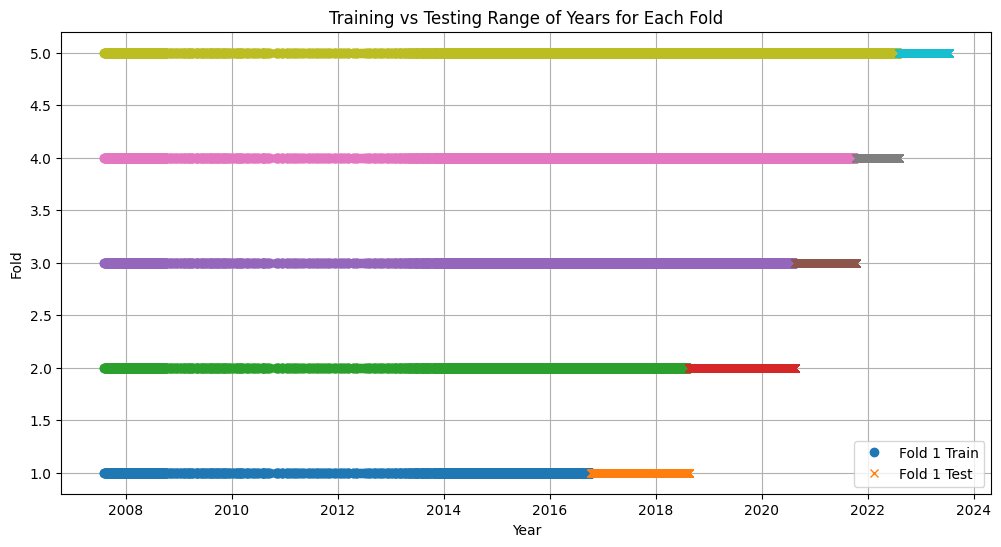

In [17]:
# Plot training vs testing years
plt.figure(figsize=(12, 6))

for i, (train, test) in enumerate(zip(train_dates_list, test_dates_list)):
    plt.plot(train, [i + 1] * len(train), 'o', label=f'Fold {i + 1} Train' if i == 0 else "")
    plt.plot(test, [i + 1] * len(test), 'x', label=f'Fold {i + 1} Test' if i == 0 else "")

plt.xlabel('Year')
plt.ylabel('Fold')
plt.title('Training vs Testing Range of Years for Each Fold')
plt.legend(loc='lower right')
plt.grid()
plt.savefig('training_vs_testing_years.png')
plt.show()



Fold 1 Confusion Matrix:
[[697 315]
 [929 598]]


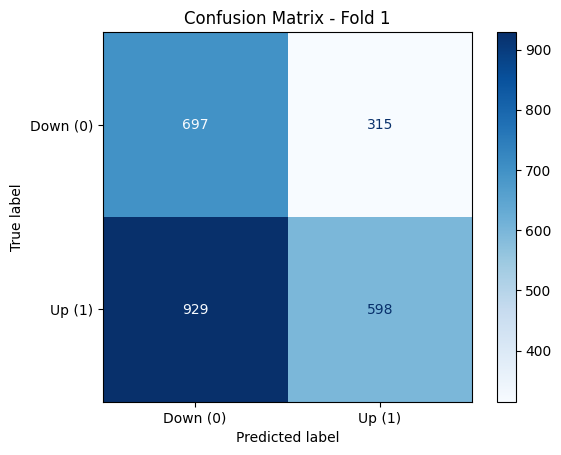

Fold 1 Accuracy: 0.51
Fold 1 MCC: 0.0820
--------------------------------------------------

Fold 2 Confusion Matrix:
[[ 443  613]
 [ 221 1262]]


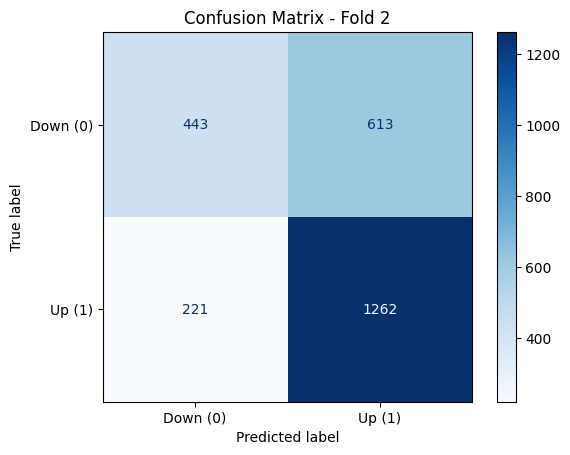

Fold 2 Accuracy: 0.67
Fold 2 MCC: 0.3034
--------------------------------------------------

Fold 3 Confusion Matrix:
[[ 235  680]
 [ 142 1482]]


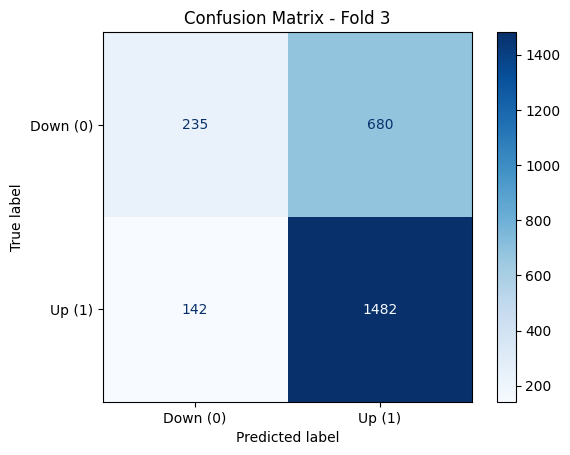

Fold 3 Accuracy: 0.68
Fold 3 MCC: 0.2287
--------------------------------------------------

Fold 4 Confusion Matrix:
[[ 708  422]
 [ 348 1061]]


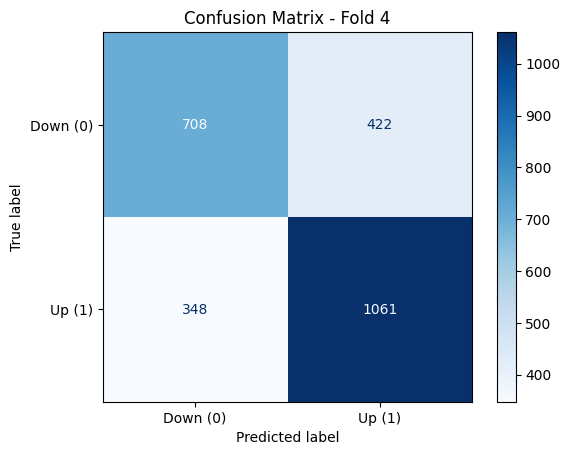

Fold 4 Accuracy: 0.70
Fold 4 MCC: 0.3827
--------------------------------------------------

Fold 5 Confusion Matrix:
[[1101  358]
 [ 288  792]]


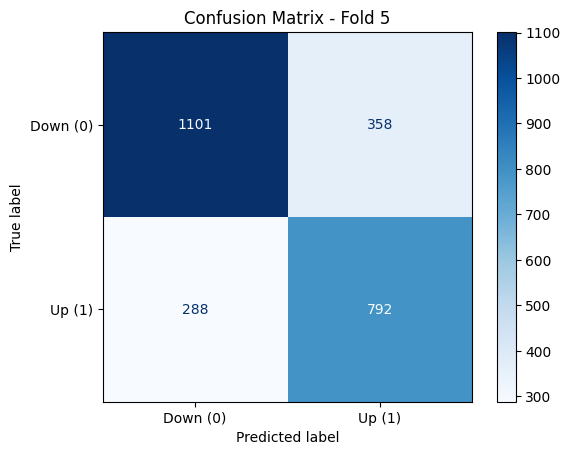

Fold 5 Accuracy: 0.75
Fold 5 MCC: 0.4846
--------------------------------------------------

Average Metrics Across Folds:
Accuracy: 0.66
Precision: 0.68
Recall: 0.73
F1-Score: 0.69
ROC-AUC: 0.66
MCC: 0.30

Overall Financial Metrics on Test Data (TimeSeriesSplit):
Directional Win Rate: 0.36
Profit Factor: 1.84
Sharpe Ratio: 2.35


In [18]:
# ---------------------------
# Assume X and y are NumPy arrays defined as:
# X: shape (n_samples, 782) with the combined market vectors
# y: shape (n_samples,) with binary target values (0 or 1)
#
# Also assume daily_returns is a NumPy array of shape (n_samples,)
# containing the daily return for each corresponding sample.
# For example:
# daily_returns = merged_data['Daily_Return'].values
# ---------------------------

# Initialize TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5)

# Initialize lists for classification metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
mcc_scores = []

# This list will store the strategy returns from all folds (in time order)
all_strategy_returns = []
total_test_days = 0  # Count total number of test days across folds

daily_returns = merged_data['Daily_Return'].values

# Perform TimeSeriesSplit
for fold, (train_index, test_index) in enumerate(tss.split(X)):
    # Directly index the NumPy arrays for training and testing splits
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize and train the Logistic Regression model
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Evaluate the model using classification metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    mcc = matthews_corrcoef(y_test, y_pred)

    # Append metrics for each fold
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)
    mcc_scores.append(mcc)

    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nFold {fold + 1} Confusion Matrix:")
    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down (0)", "Up (1)"])
    disp.plot(cmap="Blues")
    disp.ax_.set_title(f"Confusion Matrix - Fold {fold + 1}")
    plt.savefig(f'confusion_matrix_embeddings_tss_fold_{fold+1}.png')
    plt.show()

    # Print fold metrics
    print(f"Fold {fold + 1} Accuracy: {accuracy:.2f}")
    print(f"Fold {fold + 1} MCC: {mcc:.4f}")
    print("-" * 50)

    # ----------------------------------
    # FINANCIAL METRICS CALCULATION per Fold
    # ----------------------------------
    # Retrieve the daily returns for the test period using the test indices.
    # (Assumes daily_returns is aligned with X and y)
    test_returns = daily_returns[test_index]

    # Convert predictions into trading positions:
    # For a long-only strategy, use the predictions directly (1 = long, 0 = no trade)
    positions = np.array(y_pred)

    # Calculate strategy returns for this fold
    strategy_returns = positions * test_returns

    # Append these returns to the overall list and update total test days
    all_strategy_returns.extend(strategy_returns)
    total_test_days += len(strategy_returns)

# -------------------------
# Print Average Classification Metrics Across Folds
# -------------------------
print("\nAverage Metrics Across Folds:")
print(f"Accuracy: {np.mean(accuracy_scores):.2f}")
print(f"Precision: {np.mean(precision_scores):.2f}")
print(f"Recall: {np.mean(recall_scores):.2f}")
print(f"F1-Score: {np.mean(f1_scores):.2f}")
print(f"ROC-AUC: {np.mean(roc_auc_scores):.2f}")
print(f"MCC: {np.mean(mcc_scores):.2f}")

# -------------------------
# Overall Financial Metrics (computed after cross-validation)
# -------------------------
all_strategy_returns = np.array(all_strategy_returns)

if total_test_days == 0:
    directional_win_rate = np.nan
    profit_factor = np.nan
    overall_sharpe = np.nan
    print("No test days available; financial metrics are undefined.")
else:
    # Directional Win Rate: percentage of test days with a positive strategy return
    directional_win_rate = np.sum(all_strategy_returns > 0) / total_test_days

    # Profit Factor: sum of all positive returns divided by the absolute sum of all negative returns
    winning_sum = np.sum(all_strategy_returns[all_strategy_returns > 0])
    losing_sum = np.sum(all_strategy_returns[all_strategy_returns < 0])
    profit_factor = winning_sum / abs(losing_sum) if abs(losing_sum) > 1e-10 else np.nan

    # Overall Sharpe Ratio (annualized) using daily returns
    mean_return = np.mean(all_strategy_returns)
    std_return = np.std(all_strategy_returns)
    overall_sharpe = (mean_return / std_return) * np.sqrt(252) if std_return > 1e-10 else 0.0

print("\nOverall Financial Metrics on Test Data (TimeSeriesSplit):")
print(f"Directional Win Rate: {directional_win_rate:.2f}")
print(f"Profit Factor: {profit_factor:.2f}")
print(f"Sharpe Ratio: {overall_sharpe:.2f}")
